In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [37]:
torch.manual_seed(42)

In [38]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [39]:
df=pd.read_csv('fashion-mnist_train.csv')

In [40]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df.shape

(60000, 785)

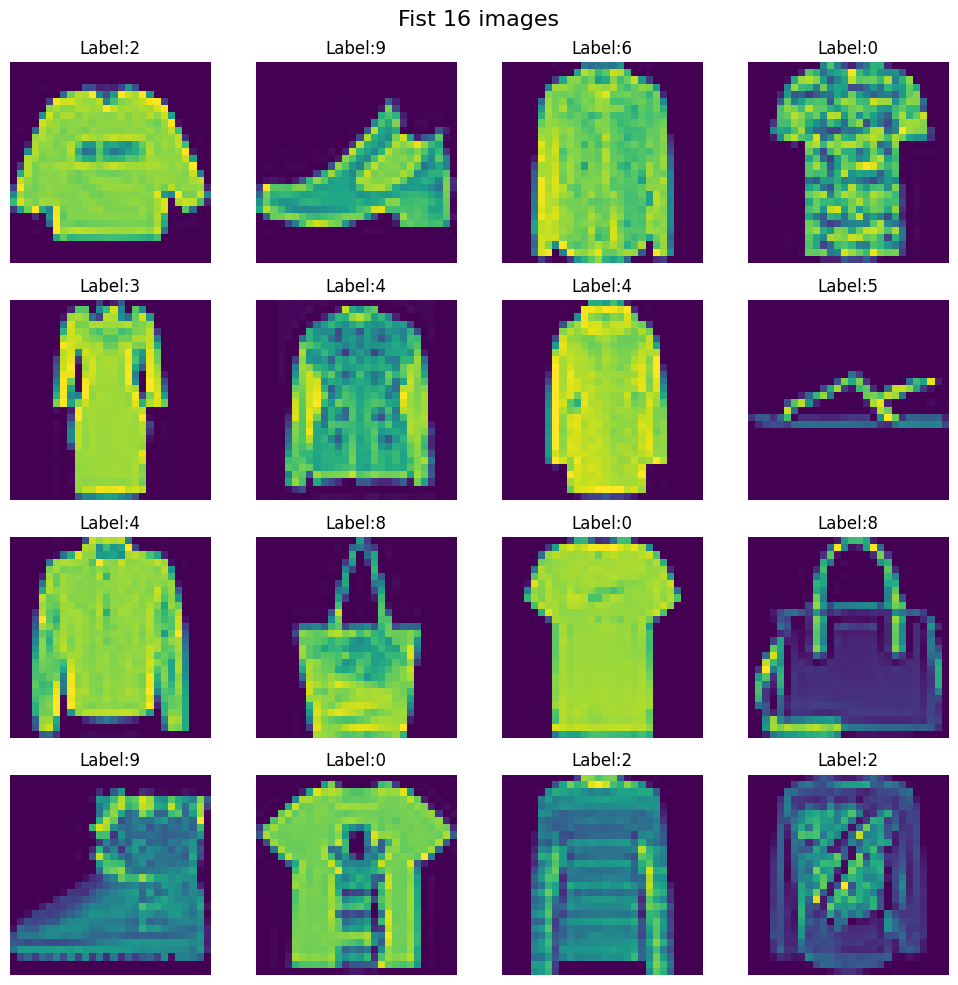

In [42]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("Fist 16 images",fontsize=16)

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label:{df.iloc[i,0]}")

plt.tight_layout()
plt.show()



In [43]:
df.iloc[:,0].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [44]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [46]:
# scaling the fetaures

X_train=X_train/255.0
X_test=X_test/255.0

In [47]:
class CustomDataset(Dataset):
  def __init__(self,fetaures,labels):
    self.fetaures=torch.tensor(fetaures,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __getitem__(self,idx):
    return self.fetaures[idx],self.labels[idx]


  def __len__(self):
    return len(self.fetaures)



In [48]:
train_dataset=CustomDataset(X_train,y_train)


In [49]:
test_dataset=CustomDataset(X_test,y_test)

In [50]:
# define NN class

class MyNN(nn.Module):

  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate):
    super().__init__()
    layers=[]

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=dropout_rate))
      input_dim=neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer,output_dim))

    self.model=nn.Sequential(*layers)


  def forward(self,x):
    return self.model(x)

In [51]:
# objective function
def objective(trial):

  # next hyperparameter values from search space
  num_hidden_layers=trial.suggest_int("num_hidden_layers",1,5)
  neurons_per_layer=trial.suggest_int("neurons_per_layer",8,128,step=8)
  epochs=trial.suggest_int("epochs",10,50,step=10)
  learning_rate=trial.suggest_float("learning_rate",1e-5,1e-1,log=True)
  dropout_rate=trial.suggest_float("dropout_rate",0.1,0.5,step=0.1)
  batch_size=trial.suggest_categorical("batch_size",[16,32,64,128])
  optimizer_name=trial.suggest_categorical("optimizer",["Adam","SGD","RMSprop"])
  weight_decay=trial.suggest_float("weight_decay",1e-5,1e-1,log=True)

  # Data loader
  train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

  # model init
  input_dim=784
  output_dim=10

  model=MyNN(input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate)
  model.to(device)


  # optimizer selection
  criterion=nn.CrossEntropyLoss()


  if optimizer_name=="Adam":
    optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  elif optimizer_name=="RMSprop":
    optimizer=optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  else:
    optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

  # training loop
  for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features,batch_labels in train_loader:

      batch_features=batch_features.to(device)
      batch_labels=batch_labels.to(device)

      outputs=model(batch_features)

      loss=criterion(outputs,batch_labels)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      total_epoch_loss=total_epoch_loss+loss.item()

    #print(f"Epoch:{epoch+1}/{epochs}, Loss:{total_epoch_loss/len(train_loader)}")



  # evaluation
  model.eval()
  total=0
  correct=0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:

      batch_features=batch_features.to(device)
      batch_labels=batch_labels.to(device)

      outputs=model(batch_features)

      _,predicted=torch.max(outputs,1)

      total=total+batch_labels.size(0)

      correct=correct+(predicted==batch_labels).sum().item()

  accuracy=correct/total


  return accuracy

In [24]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 33.5 MB/s eta 0:00:00


In [52]:
import optuna

In [53]:
study=optuna.create_study(direction='maximize')# using accuracy,loss=minimize



[I 2025-09-30 18:11:58,435] A new study created in memory with name: no-name-d829259d-a63e-4eba-89a9-ce1305f99e4c


In [54]:
study.optimize(objective,n_trials=10)

[I 2025-09-30 18:12:32,866] Trial 0 finished with value: 0.8649166666666667 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 72, 'epochs': 20, 'learning_rate': 0.0021688797140182125, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 0.00031501661409628586}. Best is trial 0 with value: 0.8649166666666667.
[I 2025-09-30 18:15:14,949] Trial 1 finished with value: 0.8806666666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 104, 'epochs': 20, 'learning_rate': 6.634879921531177e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 0.003986385772195779}. Best is trial 1 with value: 0.8806666666666667.
[I 2025-09-30 18:16:05,852] Trial 2 finished with value: 0.8443333333333334 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 96, 'epochs': 20, 'learning_rate': 0.00042347680337049886, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 0.000179855011542657

In [55]:
study.best_value

0.8859166666666667

In [56]:
study.best_params

{'num_hidden_layers': 5,
 'neurons_per_layer': 88,
 'epochs': 30,
 'learning_rate': 8.806883582102156e-05,
 'dropout_rate': 0.2,
 'batch_size': 128,
 'optimizer': 'RMSprop',
 'weight_decay': 0.009113706461349153}

In [ ]:
# MLFlow-To track all trials and also metrics
